In [100]:
#Import pickled Preprocessed DataFrame
import pickle
with open('./data/ibm_df.pickle', 'rb') as f:
    ibm_df = pickle.load(f)

In [84]:
#Import required pacakages
#Imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

#Matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 

#Numpy
import numpy as np

#Pandas
import pandas as pd
import pandas_profiling

#Seaborn
import seaborn as sns
sns.set()

#Sklearn
from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import median_absolute_error
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import (RandomForestClassifier,
                              RandomForestClassifier,
                              RandomForestRegressor,
                              GradientBoostingClassifier, 
                              ExtraTreesClassifier, #For each feature split rule is random, not optimal
                              VotingClassifier, 
                              AdaBoostClassifier, 
                              BaggingRegressor)

from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     learning_curve,
                                     validation_curve,
                                     train_test_split,
                                     cross_validate)
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
#XGBoost
from xgboost import XGBClassifier

# Check Balance of Classes
- Look at proportion of classes to see if we're dealing with balanced or imbalanced data, since each one has its own set of tools to be used when fitting classifiers

# Get number of Yes/No Attritions

Left Company Samples = 237
Remained At Company Samples = 1233
Proportion of Remained to Left Samples = 19.22%


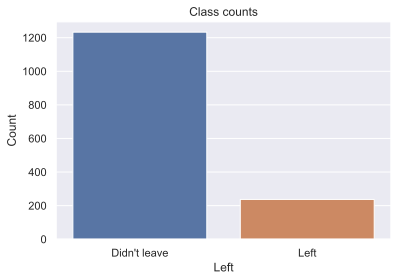

In [101]:
pos = ibm_df[ibm_df["Attrition"] == 1].shape[0]
neg = ibm_df[ibm_df["Attrition"] == 0].shape[0]
print("Left Company Samples = {}".format(pos))
print("Remained At Company Samples = {}".format(neg))
print("Proportion of Remained to Left Samples = {:.2f}%".format((pos / neg) * 100))
sns.countplot(ibm_df["Attrition"])
plt.xticks((0, 1), ["Didn't leave", "Left"])
plt.xlabel("Left")
plt.ylabel("Count")
plt.title("Class counts");

<h3> We have an imbalanced dataset.</h3> 
As a result, when we fit classifiers on such datasets, we should use metrics other than accuracy when comparing models such as:

- F1 Score
- AUC (Area under ROC Curve)

Moreover, class imbalance influences a learning algorithm during training by making the decision rule biased towards the majority class by implicitly learning a model that optimized the predictions based on the majority class in the dataset. There are three ways to deal with this issue.

- Assign a larger penalty to wrong predictions from the minority class
- Upsampling the minority class or downsampling the majority class
- Generate synthetic training examples

Steps to Address This

First:
- split the data into training and test sets using 80/20 split; 80% of the data will be used to train the models and 20% to test the performance of the models. 
Second: 
- Upsample the minority class and downsample the majority class. For this data set, positive class is the minority class and negative class is the majority class.

In [102]:
X = ibm_df.loc[:, ibm_df.columns != "Attrition"].values
y = ibm_df.loc[:, ibm_df.columns == "Attrition"].values.flatten()

In [103]:
#Split the data 80 - 20  train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=1)

Notes: 

Stratified sampling aims at splitting one data set so that each split are similar with respect to something.

In a classification setting, it is often chosen to ensure that the train and test sets have approximately the 
same percentage of samples of each target class as the complete set.

As a result, if the data set has a large amount of each class, stratified sampling is pretty much the same as 
random sampling. But if one class isn't much represented in the data set, which may be the case in your dataset 
since you plan to oversample the minority class, then stratified sampling may yield a different target class 
distribution in the train and test sets than what random sampling may yield.

In [104]:
# Now add some random oversampling of the minority classes using imblearn
ros = RandomOverSampler(random_state=0)
X_resampled_up, y_resampled_up = ros.fit_sample(X_train,y_train)


We always oversample after splitting into training and validation datasets inorder to prevent bleed information from the
validation set into the training of the model. If I upsample a dataset before splitting it into a train and validation set, 
I could end up with the same ovbservation in both datasets. As a result a complex enough model will be able to perfectly predict
the value for those observations when predicting on the validation set, inflating the accuracy and recall. 


In [105]:
#Smote Random Oversampling
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

In [106]:
#ADASYN Random Oversampling
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train,y_train)

In [107]:
print("Original shape:", X_train.shape, y_train.shape)
print("Random Upsampled Shape:", X_resampled_up.shape, y_resampled_up.shape)
print("SMOTE Upsampled Shape:", X_smoted.shape, y_smoted.shape)
print("ADASYN Upsampled Shape:", X_adasyn.shape, y_adasyn.shape)

Original shape: (882, 40) (882,)
Random Upsampled Shape: (1480, 40) (1480,)
SMOTE Upsampled Shape: (1480, 40) (1480,)
ADASYN Upsampled Shape: (1451, 40) (1451,)


In [108]:
#Downsample the majority class
X_resampled_down, y_resampled_down = RandomUnderSampler(random_state=0).fit_sample(X_train,y_train)

In [109]:
print("Original shape:", X_train.shape, y_train.shape)
print("Random Undersampled Shape:", X_resampled_down.shape, y_resampled_down.shape)

Original shape: (882, 40) (882,)
Random Undersampled Shape: (284, 40) (284,)


In [110]:
#Randomly Upsample the minority class.
X_train_up, y_train_up = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True, # sample with replacement
                                n_samples=X_train[y_train == 0].shape[0],# to match majority class
                                random_state=1) # reproducible results

X_train_up = np.concatenate((X_train[y_train == 0], X_train_up))
y_train_up = np.concatenate((y_train[y_train == 0], y_train_up))

In [111]:
#Randomly Downsample the minority class.

X_train_down, y_train_down = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True, # sample with replacement
                                n_samples=X_train[y_train == 1].shape[0],# to match majority class
                                random_state=1) # reproducible results

X_train_down = np.concatenate((X_train[y_train == 1], X_train_down))
y_train_down = np.concatenate((y_train[y_train == 1], y_train_down))

In [112]:
print("Original shape:", X_train.shape, y_train.shape)
print("Random Upsampled shape:", X_train_up.shape, y_train_up.shape)
print("Random Downsampled shape:", X_train_down.shape, y_train_down.shape)

Original shape: (882, 40) (882,)
Random Upsampled shape: (1480, 40) (1480,)
Random Downsampled shape: (284, 40) (284,)


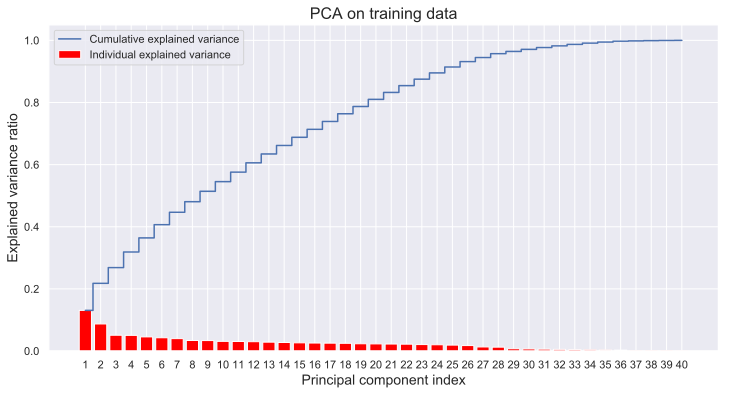

In [115]:
#It’s good to see how many principal components needed to explain 90%, 95% and 99% of the variation in the data.
pca = PCA(n_components=None, svd_solver="full")
pca.fit(StandardScaler().fit_transform(X_train))
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 6))
plt.bar(range(1, 41), pca.explained_variance_ratio_, align="center",
        color='red', label="Individual explained variance")
plt.step(range(1, 41), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.xticks(range(1, 41))
plt.legend(loc="best")
plt.xlabel("Principal component index", {"fontsize": 14})
plt.ylabel("Explained variance ratio", {"fontsize": 14})
plt.title("PCA on training data", {"fontsize": 16});

In [116]:
cum_var_exp

array([0.13078337, 0.21783578, 0.26851568, 0.31878834, 0.36415553,
       0.40677558, 0.44668433, 0.48061152, 0.51413267, 0.54524685,
       0.57579663, 0.6057866 , 0.63427979, 0.66168688, 0.68801662,
       0.71362077, 0.73895316, 0.76374608, 0.78708616, 0.81007154,
       0.83242973, 0.8543598 , 0.87513683, 0.89530895, 0.91429031,
       0.93170452, 0.94473758, 0.95718893, 0.96439313, 0.97104353,
       0.97697315, 0.98233888, 0.98707005, 0.99117375, 0.99453176,
       0.99737289, 0.99832525, 0.99918872, 0.99976418, 1.        ])

In [17]:
#95% of the variance in our data is explained by 25 of our features and 99%  of the variance is explained by 33 of our features

The methodology that I’ll follow when building the classifiers goes as follows:

Build a pipeline that handles all the steps when fitting the classifier using scikit-learn’s `make_pipeline` which will have two steps:

I. Standardizing the data to speed up convergence and make all features on the same scale.

II. The classifier (estimator) we want to use to fit the model.

2. Use GridSearchCV to tune hyperparameters using 10-folds cross validation. We can use RandomizedSearchCV which is faster and may outperform GridSearchCV especially if we have more than two hyperparameters and the range for each one is very big; however, GridSearchCV will work just fine since we have only two hyperparameters and descent range.

3. Fit the model using training data.

4. Plot both confusion matrix and ROC curve for the best estimator using test data.

Repeat the above steps for `Random Forest`, `Gradient Boosting Trees`, `K-Nearest Neighbors`, `Logistic Regression` and `Support Vector Machine`. Next, pick the classifier that has the highest cross validation f1 score.

# Model 1 - Random Forest
First, fit a random forest classifier using `unsampled`, `upsampled`, and `downsampled` data. Second, evaluate each method using cross validation CV f1-score and pick the one with the highest CV F1 score. The best method will be used to fit the rest of the classifiers

Hyperparameters to tune:

`max_features`: How many features to consider randomly on each split to help avoid having few strong features to be picked on each split and let other features have the chance to contribute. The predictions will be less correlated and the variance of each tree will decrease.

`min_samples_leaf`: How many examples to have for each split to be a final leaf node.

In [18]:


'''
Decision Trees are prone to high variance. Comes at cost of overfitting the training set.

Huristic: Greedy Search
Informatino Entropy
Split wiht entrop minimization rule
Boostrap Aggregating - Sample with Replacement

Ensemble Methods Random Forests
Introduce randomness when building each tree.
For a split, do not take the “best” feature split.
First, randomly choose sqrt(n_feat) features.
Only choose the best split among these.

Bagging - Reduces Bagging
-Average Voting
-Max Voting
looking at bootstrapped samples and running several different models on the data allows the classifier to 
find the best aggregate model that will generalize best to our data.

'''

'\nDecision Trees are prone to high variance. Comes at cost of overfitting the training set.\n\nHuristic: Greedy Search\nInformatino Entropy\nSplit wiht entrop minimization rule\nBoostrap Aggregating - Sample with Replacement\n\nEnsemble Methods Random Forests\nIntroduce randomness when building each tree.\nFor a split, do not take the “best” feature split.\nFirst, randomly choose sqrt(n_feat) features.\nOnly choose the best split among these.\n\nBagging - Reduces Bagging\n-Average Voting\n-Max Voting\nlooking at bootstrapped samples and running several different models on the data allows the classifier to \nfind the best aggregate model that will generalize best to our data.\n\n'

In [117]:
#Confirm our model is overfitting
dt_model = DecisionTreeRegressor(random_state=123)
dt_model.fit(X_train,y_train)
print(f'Train R^2 Score: {np.round(dt_model.score(X_train, y_train), 4)}')
print(f'Test R^2 Score: {np.round(dt_model.score(X_test, y_test), 4)}')

Train R^2 Score: 1.0
Test R^2 Score: -0.5955


In [118]:
def bias_metric(y_true, y_pred):
    return np.mean((np.mean(y_pred) - y_true)**2)

def variance_metric(y_true, y_pred):
    return np.var(y_true - y_pred)

In [119]:
variance = []
bias = []
test_range = np.arange(1, 30, 1)

for i in test_range:
    cv_out = cross_validate(
        estimator=BaggingRegressor(
            DecisionTreeRegressor(random_state=123), n_estimators=i),
        X=X_train,
        y=y_train,
        cv=3,
        return_train_score=True,
        scoring={
            "variance": make_scorer(variance_metric),
            "bias": make_scorer(bias_metric)
        },
        n_jobs=-1,
    )
    variance.append(np.mean(cv_out['test_variance']))
    bias.append(np.mean(cv_out['test_bias']))

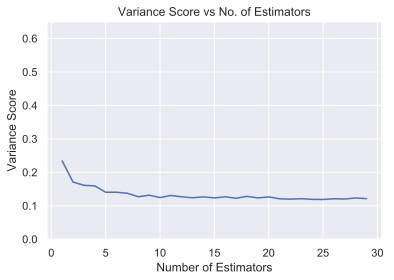

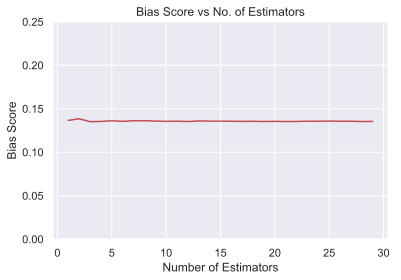

In [120]:
plt.figure(dpi=150)
plt.plot(test_range, variance, label='variance')
plt.ylim((0, 0.65))
plt.xlabel('Number of Estimators')
plt.ylabel('Variance Score');
plt.title('Variance Score vs No. of Estimators');

plt.figure(dpi=150)
plt.plot(test_range, bias, label='bias', c='r')
plt.ylim((0, 0.25))
plt.xlabel('Number of Estimators')
plt.ylabel('Bias Score');
plt.title('Bias Score vs No. of Estimators');

In [121]:
# Build random forest classifier
def random_forest_classifier(X_train, y_train):
    methods_data = {"Original": (X_train, y_train),
                    "Upsampled": (X_train_up, y_train_up),
                    "Downsampled": (X_train_down, y_train_down)}

    for method in methods_data.keys():
        pip_rf = make_pipeline(StandardScaler(),
                               RandomForestClassifier(n_estimators=500, #Typically Sufficient
                                                      class_weight="balanced",
                                                      random_state=123))

        hyperparam_grid = {
            "randomforestclassifier__n_estimators": [10, 50, 100, 200, 500],
            "randomforestclassifier__max_features": ["sqrt", "log2", 0.4, 0.5], #sqrt/log2 => max_features = sqrt/log2(n_features), 
            "randomforestclassifier__min_samples_leaf": [1, 3, 5, 10, 20, 30],
            "randomforestclassifier__criterion": ["gini", "entropy"]}

        gs_rf = GridSearchCV(pip_rf,
                             hyperparam_grid,
                             scoring="f1", #The F1 score can be interpreted as a weighted average of the precision and recall, 
                             #where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of 
                             #precision and recall to the F1 score are equal. The formula for the F1 score is:
                             cv=10, # Number of K-fold cross validation
                             n_jobs=-1) # Setting n_jobs to -1, specifys that all CPUs are used

        gs_rf.fit(methods_data[method][0], methods_data[method][1])

        print(f"\033[1m\033[0mThe best hyperparameters for {method} data:")
        for hyperparam in gs_rf.best_params_.keys():
            print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_rf.best_params_[hyperparam])

        print(f"\033[1m\033[94mBest 10-folds CV f1-score: {gs_rf.best_score_ * 100:.2f}%.")

In [55]:
random_forest_classifier(X_adasyn, y_adasyn)

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best hyperparameters for Original data:
criterion :  gini
max_features :  0.4
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 88.70%.
The best hyperparameters for Upsampled data:
criterion :  entropy
max_features :  log2
min_samples_leaf :  1
n_estimators :  200
Best 10-folds CV f1-score: 98.53%.
The best hyperparameters for Downsampled data:
criterion :  gini
max_features :  log2
min_samples_leaf :  3
n_estimators :  50
Best 10-folds CV f1-score: 75.23%.


C:\Users\moham\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Upsampling produced the highest CV F1-score with 98.53%. The upsampled data will be used to fit the rest of the classifiers. 

In [24]:
X_train_up[y_train_up == 0].shape, X_train_up[y_train_up == 1].shape

((740, 39), (740, 39))

In [51]:
def Random_Forest_Classifier(X_train_up, y_train_up,):
    # Reassign original training data to upsampled data
    X_train_re, y_train_re = np.copy(X_train_up), np.copy(y_train_up)

    # Refit RF classifier using best params
    clf_rf = make_pipeline(StandardScaler(),
                           RandomForestClassifier(n_estimators=200,
                                                  criterion="entropy",
                                                  max_features='log2',
                                                  min_samples_leaf=1,
                                                  class_weight="balanced",
                                                  n_jobs=-1,
                                                  random_state=123))
    clf_rf.fit(X_train_re, y_train_re)
        
    return 

In [56]:
clf_RandomForest = Random_Forest_Classifier(X_adasyn, y_adasyn)

In [57]:
#Save fitted model
filename = './data/RandomForest_model_1_adasyn.sav'
pickle.dump(clf_RandomForest, open(filename, 'wb'))

In [93]:
#Import fitted model
with open('./data/RandomForest_model_1_adasyn.sav', 'rb') as f:
    clf_RandomForest = pickle.load(f)

In [94]:
# Reassign original test data to upsampled data
X_test_re, y_test_re = np.copy(X_test), np.copy(y_test)

Let’s refit the Random Forest with Upsampled data using best hyperparameters tuned above and plot confusion matrix and ROC curve using test data.

In [95]:
y_pred = clf_RandomForest.predict(X_test) 

In [96]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[244   3]
 [ 37  10]]


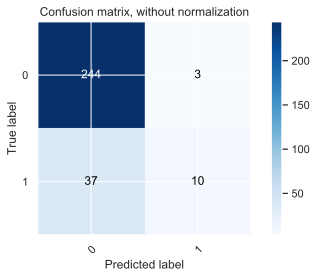

In [97]:
# Plot non-normalized confusion matrix
cm = plot_confusion_matrix(y_test, y_pred,
                      title='Confusion matrix, without normalization')


Normalized confusion matrix
[[0.98785425 0.01214575]
 [0.78723404 0.21276596]]


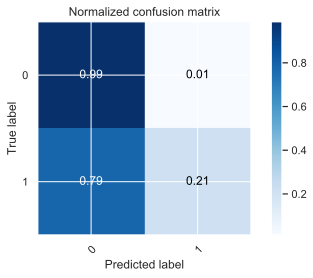

In [98]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True,
                      title='Normalized confusion matrix')

In [99]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       247
           1       0.77      0.21      0.33        47

   micro avg       0.86      0.86      0.86       294
   macro avg       0.82      0.60      0.63       294
weighted avg       0.85      0.86      0.83       294

